<h1>Business Understanding</h1>

Phase one of the CRISP-DM process includes the project objectives
and requirements.
<br>
In our case, I have chosen the latest Airbnb listing data from Cape Town. My objective is to explore and better understand the following questions:

1) when are the most popular times to hike up the prices of listings;
2) which areas have the most expensive listings on average and;
3) what contributes most to the price of a listing.

In [46]:
import pandas as pd
import geopandas as geopd
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

In [47]:
calendar_df = pd.read_csv('calendar.csv.gz', compression='gzip')
listings_df = pd.read_csv('listings.csv.gz', compression='gzip')
reviews_df = pd.read_csv('reviews.csv.gz', compression='gzip')

ward_geo = geopd.read_file('neighbourhoods.geojson')

<h1>Data Understanding</h1>

In order to understand the nature and the quality of the data, I do some initial exploring.

In [14]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23095 entries, 0 to 23094
Columns: 106 entries, id to reviews_per_month
dtypes: float64(26), int64(21), object(59)
memory usage: 18.7+ MB


In [15]:
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3191,https://www.airbnb.com/rooms/3191,20190720185720,2019-07-21,Malleson Garden Cottage,"This is a lovely, separate, self-catering cott...",Beautiful self catering luxury cottage in cent...,"This is a lovely, separate, self-catering cott...",none,"Mowbray is on the Southern Suburbs line, 6km (...",...,t,f,moderate,f,f,1,1,0,0,0.64
1,13044,https://www.airbnb.com/rooms/13044,20190720185720,2019-07-21,*WINTER OFFER* JAMBO Guest House / Green Room,ASK US ABOUT OUR WINTER DISCOUNTS! The Green R...,"Jambo, which means hello in Swahili, is a gues...",ASK US ABOUT OUR WINTER DISCOUNTS! The Green R...,none,Green Point is a popular leisure district domi...,...,t,f,strict_14_with_grace_period,f,f,5,0,5,0,0.02
2,15007,https://www.airbnb.com/rooms/15007,20190720185720,2019-07-21,Blaauwberg House,Welcome to our self-catering beach-front famil...,The house sleeps 6 and has all necessary ameni...,Welcome to our self-catering beach-front famil...,none,"Bloubergstrand is a lovely, cosy suburb near C...",...,f,f,strict_14_with_grace_period,f,f,4,4,0,0,0.38
3,15068,https://www.airbnb.com/rooms/15068,20190720185720,2019-07-21,Grande Bay,Modern spacious apartment. Three bedrooms two...,Self catering. Lovely three bedroom apartment ...,Modern spacious apartment. Three bedrooms two...,none,Close to Eden on The Bay and lots of restauran...,...,f,f,strict_14_with_grace_period,f,f,13,13,0,0,NaN
4,15077,https://www.airbnb.com/rooms/15077,20190720185720,2019-07-21,Top relaxed beach living in style,Situated either on the ground floor with direc...,"A stunning architect designed guesthouse, Suns...",Situated either on the ground floor with direc...,none,It is probably the best hub in order to explor...,...,f,f,strict_14_with_grace_period,f,f,5,1,4,0,0.06


In [16]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8429758 entries, 0 to 8429757
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 450.2+ MB


In [17]:
calendar_df.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3191,2019-07-21,f,$544.00,$544.00,3.0,730.0
1,302227,2019-07-20,f,$556.00,$556.00,360.0,360.0
2,302227,2019-07-21,f,$556.00,$556.00,360.0,360.0
3,302227,2019-07-22,t,$556.00,$556.00,360.0,360.0
4,302227,2019-07-23,t,$556.00,$556.00,360.0,360.0


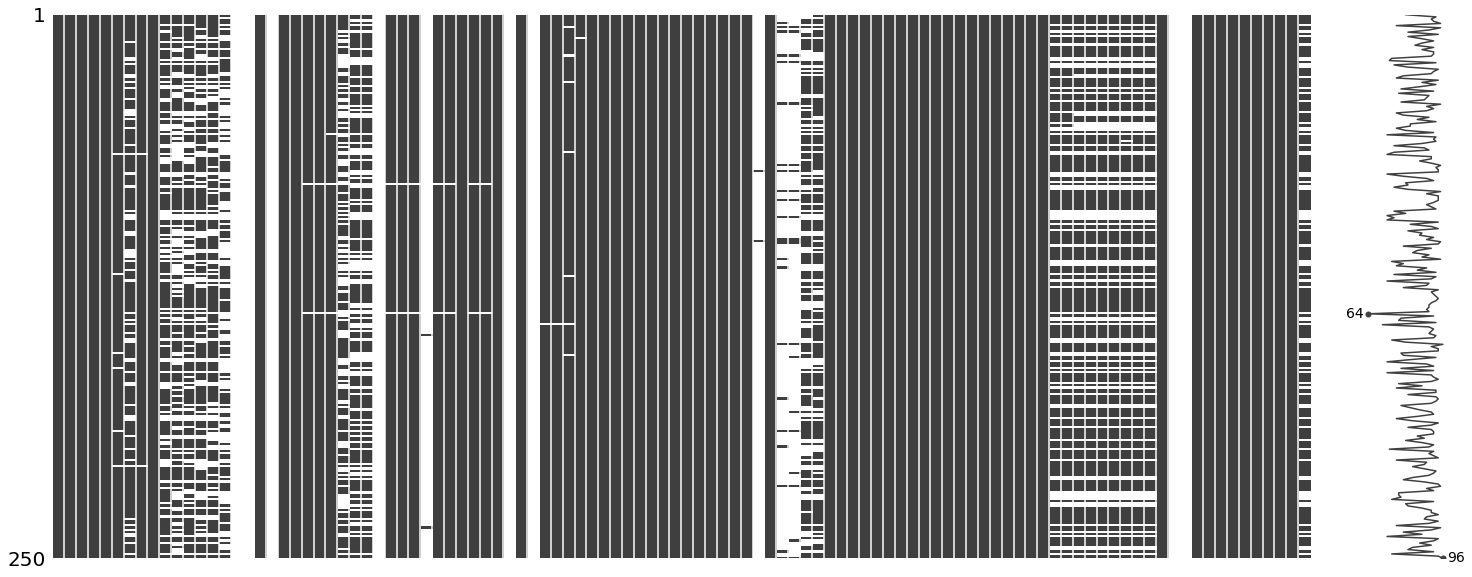

In [18]:
msno.matrix(listings_df.sample(250))

Based on the above structure of the dataset, for the purposes of my business understanding, the features that I am most interested in are found in calendar_df. Although, the features within listings_df are the most interesting.

Dealing with listings_df, however, requires some cleaning and cutting of columns to have a smaller more succint df that can accommodate my questions. For this I identified the columns that potentially hold relevant location data first. For the purposese of the analysis, I'll use the columns which include up to 30 unique categories. Laslty, I'm including all the numerical columns which are ints and floats.

<h1>Data Preparation</h1>

First I'll identify and remove the columns that are 100% empty as they serve no significance in my exploration analysis. I will replace the empty rows of my numerical columns with the mean of that column. I've decided to inpute missing row values with the mean because for purposes of my analysis and the size of the dataset, it's easy and fast compared to other methods as listed <a src="https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779">here</a> by Will Badr.

In [19]:
listings_df.dropna(how='all', inplace=True)

In [20]:
# return listings which are relevant to location data

location_listings_df = listings_df[['id', 'street',
             'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
             'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country',
             'latitude', 'longitude', 'is_location_exact']]

In [21]:
def get_cat_columns(df):
    
    '''
    Requires df that could includes
    columns in:
    
    1) location_listings_df
    2) categories less than 30
    3) columns with floats and ints
    
    Returns df that satisfies the above.
    '''
    
    cat_cols = []
    
    for col in df.columns:
        
        # include column if it's categories are lower than 30
        if len(df[col].value_counts()) < 30:
            cat_cols.append(col)
            
        # include column if it's in property details
        elif col in list(location_listings_df.columns):
            cat_cols.append(col)
        
        # include column if it's numeric
        num_cols = listings_df.select_dtypes(include=['float', 'int']).columns
        
        # if the row value is empty take the mean value
        for col in num_cols:
            listings_df[col].fillna((listings_df[col].mean()), inplace=True)
            cat_cols.append(col)
    
    # ensure all duplicates are removed        
    cat_cols = list(set(cat_cols))
        
    return df[cat_cols]

In [23]:
listings_df = get_cat_columns(listings_df)

Based on my initial data exploration, I need to re-format the date column as well as the price columns of calendar_df.

In [24]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [25]:
def remove_dollar(value):
    
    '''
    Requires string value
    Returns float without $ sign and comma sign.
    '''
    
    value = value.replace('$', '')
    value = value.replace(',', '')
    return float(value)

In [26]:
calendar_df['adjusted_price'] = calendar_df['adjusted_price'].apply(remove_dollar)
calendar_df['price'] = calendar_df['price'].apply(remove_dollar)

<h1>Modeling</h1>

For the purposes of this exercise, no modeling of the data is reqiured. Instead, descriptive or inferential statistics will be used to better explore the questions put forward in my business understanding.

<h2>1. When are the most popular times to hike up the price?</h2>

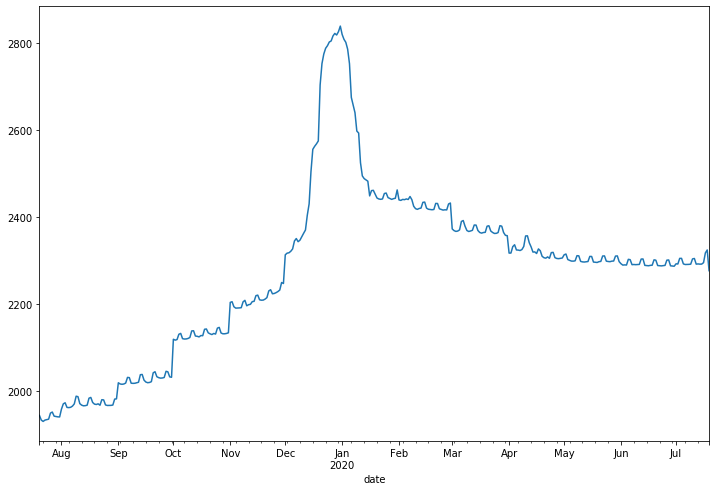

In [27]:
calendar_df['adjusted_price'].groupby(calendar_df['date']).mean().plot(figsize=(12, 8))

In [28]:
available_df = calendar_df[calendar_df['available'] == 't']
not_available_df = calendar_df[calendar_df['available'] == 'f']

In [29]:
available_df['adjusted_price'].mean() - not_available_df['adjusted_price'].mean()

191.19861026579702

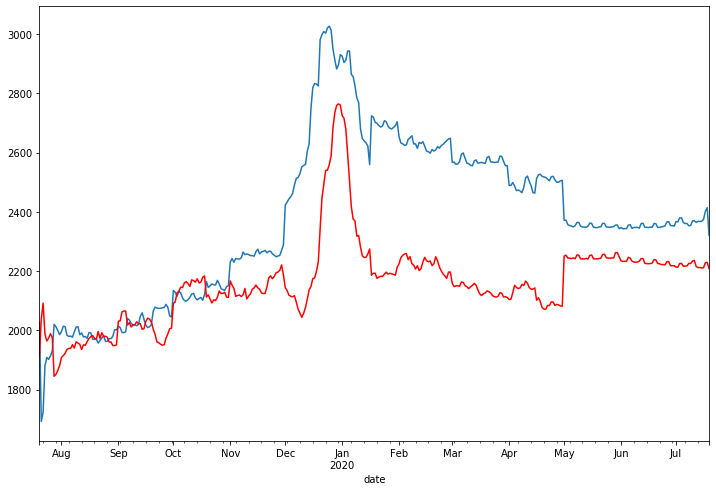

In [30]:
available_df['adjusted_price'].groupby(available_df['date']).mean().plot(figsize=(12, 8))
not_available_df['adjusted_price'].groupby(not_available_df['date']).mean().plot(figsize=(12, 8),
                                                                                 color='red')

In [31]:
def get_listing_mean(listing_id):
    
    '''
    Requires numerical integer listing ID
    Returns float mean value.
    '''
    
    return calendar_df[calendar_df['listing_id'] == listing_id]['adjusted_price'].mean()

def get_listing_min(listing_id):
    
    '''
    Requires numerical integer listing ID
    Returns float min value.
    '''
    
    return calendar_df[calendar_df['listing_id'] == listing_id]['adjusted_price'].min()

def get_listing_max(listing_id):
    
    '''
    Requires numerical integer listing ID
    Returns float max value.
    '''
    
    return calendar_df[calendar_df['listing_id'] == listing_id]['adjusted_price'].max()

In [32]:
price_df = calendar_df['listing_id'].value_counts().reset_index()
price_df.columns = ['listing_id', 'days_available']

In [33]:
price_df['mean_price'] = price_df['listing_id'].apply(get_listing_mean)

In [34]:
price_df['min_price'] = price_df['listing_id'].apply(get_listing_min)

In [35]:
price_df['max_price'] = price_df['listing_id'].apply(get_listing_max)

In [36]:
price_df.drop('days_available', axis=1, inplace=True)

<h2>2. Which areas are the most expensive?</h2>

In [37]:
df = pd.merge(listings_df, price_df, left_on='id', right_on='listing_id')
df.dropna(how='all', axis=1, inplace=True)

In [38]:
listings_df.columns

Index(['instant_bookable', 'maximum_nights', 'smart_location', 'longitude',
       'number_of_reviews_ltm', 'host_total_listings_count', 'availability_60',
       'number_of_reviews', 'neighbourhood', 'accommodates', 'market',
       'license', 'minimum_nights_avg_ntm',
       'calculated_host_listings_count_private_rooms',
       'maximum_minimum_nights', 'cancellation_policy', 'country',
       'neighbourhood_group_cleansed', 'minimum_minimum_nights',
       'maximum_maximum_nights', 'maximum_nights_avg_ntm', 'availability_90',
       'calculated_host_listings_count_shared_rooms', 'review_scores_checkin',
       'host_response_time', 'square_feet', 'review_scores_rating',
       'neighbourhood_cleansed', 'city', 'minimum_nights',
       'host_identity_verified', 'bathrooms', 'xl_picture_url', 'medium_url',
       'host_is_superhost', 'requires_license', 'id', 'minimum_maximum_nights',
       'host_has_profile_pic', 'is_location_exact', 'availability_365',
       'state', 'latitude', 

In [39]:
df.sort_values('mean_price', ascending=True)[['neighbourhood_cleansed',
                                               'smart_location',
                                               'mean_price', 'bathrooms',
                                               'accommodates', 'square_feet',
                                               'bedrooms', 'guests_included',
                                               'listing_id'
                                              ]].head(10)

,neighbourhood_cleansed,smart_location,mean_price,bathrooms,accommodates,square_feet,bedrooms,guests_included,listing_id
21172,Ward 11,"Cape Town, South Africa",127.920548,1.0,1,910.493671,1.0,1,33738120
10317,Ward 11,"Cape Town , South Africa",131.000000,1.0,1,910.493671,1.0,1,18442126
10580,Ward 11,"Kuils River, South Africa",131.000000,1.5,1,910.493671,1.0,1,18973684
5250,Ward 54,"Cape Town, South Africa",132.000000,2.5,8,910.493671,4.0,1,11348030
16499,Ward 64,"Cape Town, South Africa",138.443836,1.0,1,910.493671,1.0,1,27919539
4195,Ward 115,"Cape Town, South Africa",139.000000,1.0,2,910.493671,1.0,1,9748745
549,Ward 43,"Cape Town, South Africa",140.000000,3.0,16,910.493671,12.0,1,2081369
21347,Ward 43,"Cape Town, South Africa",145.000000,5.0,16,910.493671,14.0,1,34033564
19594,Ward 115,"Cape Town, South Africa",145.178082,3.0,4,910.493671,1.0,1,31558004
19596,Ward 115,"Cape Town, South Africa",145.561644,3.0,4,910.493671,1.0,1,31558609


In [40]:
df.sort_values('mean_price', ascending=False)[['neighbourhood_cleansed',
                                               'smart_location',
                                               'mean_price', 'bathrooms',
                                               'accommodates', 'square_feet',
                                               'bedrooms', 'guests_included',
                                               'listing_id'
                                              ]].head(10)

,neighbourhood_cleansed,smart_location,mean_price,bathrooms,accommodates,square_feet,bedrooms,guests_included,listing_id
22378,Ward 74,"Hout Bay , South Africa",300000.000000,1.5,4,910.493671,1.0,2,35597310
16212,Ward 54,"Cape Town, South Africa",252739.726027,6.0,12,910.493671,6.0,12,27367686
14917,Ward 54,"Cape Town, South Africa",161260.273973,6.0,12,910.493671,6.0,12,24230850
22389,Ward 74,"Hout Bay, South Africa",150000.000000,1.5,1,910.493671,1.0,1,35634993
22032,Ward 54,"Cape Town, South Africa",147000.000000,6.0,12,910.493671,6.0,1,35212572
14927,Ward 54,"Cape Town, South Africa",146712.328767,6.0,10,910.493671,6.0,10,24231503
22464,Ward 106,"Cape Town, South Africa",144788.000000,1.0,2,910.493671,2.0,1,35795956
11243,Ward 100,"Cape Town, South Africa",140000.000000,0.0,1,910.493671,0.0,1,20444799
6,Ward 115,"Cape Town, South Africa",125000.000000,1.0,2,910.493671,1.0,3,15199
15004,Ward 54,"Cape Town, South Africa",106356.164384,4.0,8,910.493671,4.0,8,24349838


In [41]:
def get_ward_mean(ward_name):
    
    '''
    Requires string ward name
    Returns float mean value.
    '''
    
    return df[df['neighbourhood_cleansed'] == ward_name]['mean_price'].mean()

In [42]:
df['ward_mean'] = df['neighbourhood_cleansed'].apply(get_ward_mean)

In [43]:
ward_mean_df = df[['neighbourhood_cleansed', 'ward_mean']]
ward_mean_df.columns = ['ward', 'ward_mean']
ward_mean_df.drop_duplicates(subset='ward', inplace=True)

//anaconda3/envs/data-sci/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
wards = pd.merge(ward_geo, ward_mean_df,
                 left_on='neighbourhood',
                right_on='ward')

wards.drop(['neighbourhood_group', 'neighbourhood'], axis=1, inplace=True)

In [49]:
# One ward's mean was an anomaly and had to be removed 

wards = wards.sort_values('ward_mean', ascending=False).drop(23)

In [50]:
folium_map = folium.Map(location=[-33.9249, 18.4241],
               zoom_start=9.6)

In [51]:
# Add colour fill for municipality boundaries layer

folium.Choropleth(
    geo_data=ward_geo,
    data=wards,
    columns=['ward', 'ward_mean'],
    key_on= 'properties.neighbourhood',
    fill_color='RdYlBu',
    line_opacity=0.2,
    nan_fill_color='#ff845e'
).add_to(folium_map)

In [52]:
folium_map

<h2>3. What contributes most to the price of listings?</h2>

In [53]:
corr_df = df.corr().sort_values('mean_price', ascending=False)['mean_price'].reset_index()
corr_df.columns = ['feature', 'corr']
corr_df['corr_abs'] = corr_df['corr'].abs()

In [54]:
corr_df = corr_df.sort_values('corr_abs', ascending=False).head(20)

In [55]:
format_dict = {'sum':'${0:,.0f}', 'date': '{:%m-%Y}', 'pct_of_total': '{:.2%}'}

In [56]:
(corr_df
 .style
 .format(format_dict)
 .hide_index()
 .bar(color='lightgreen', subset=['corr_abs'], align='zero')
 .set_caption('Biggest correlations with listings price'))

feature,corr,corr_abs
mean_price,1,1
min_price,0.96729,0.96729
max_price,0.897887,0.897887
bathrooms,0.404486,0.404486
accommodates,0.376341,0.376341
bedrooms,0.346584,0.346584
ward_mean,0.300714,0.300714
beds,0.249683,0.249683
guests_included,0.186127,0.186127
longitude,-0.113874,0.113874


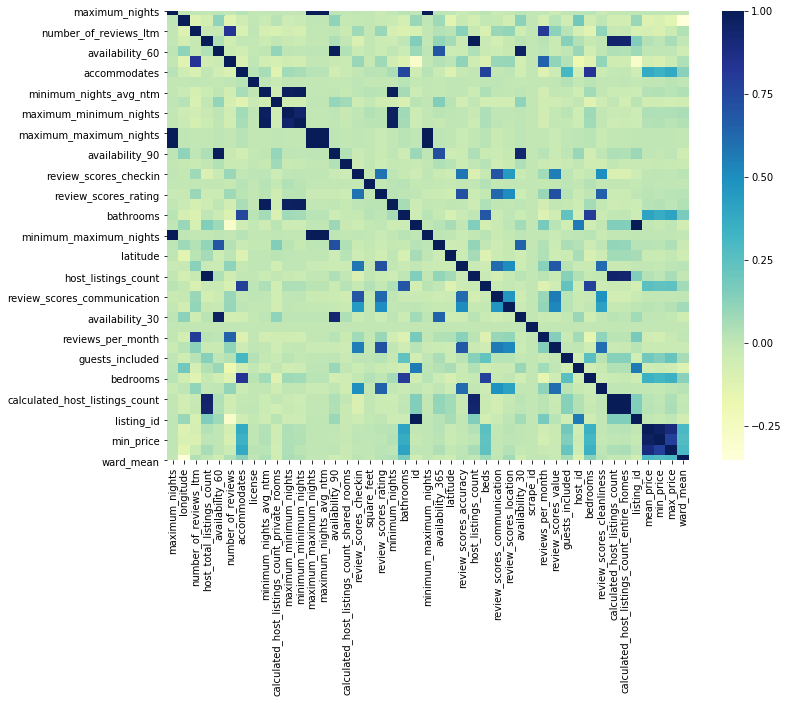

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.heatmap(df.corr(), cmap="YlGnBu", ax=ax)

<h1>Evaluation</h1>

Some of the findings include that costs are lowest the closer we more to the present date. This is perhaps an indicator that hosts tend to rake up prices over the long run and bring them down as the date approaches to fill up more rooms.

The Atlantic Seaboard are the most expensive along with the inner City. Specific neighbourhoods include Camps Bay and Hout Bay.

Large price correlations include the number of bathrooms, accommodates, square feet and bedrooms.

Going forward, the above findings and dataset can be used for machine learning purposes to predict the price of listings throughout the year. Some business business objectives that could have been addressed earlier include testing smarter ways to deal with missing values, applying and testing model accuracy for price prediction and exploring the reviews_df dataset.

For the <b>Deployment Phase</b> this notebook and it's findings will be published in a non-technical Medium post which can be found <a src="https://medium.com/@plan__b/this-airbnb-data-will-make-you-think-twice-about-cape-town-accommodation-costs-7d31e90178eb">here</a> and a Github repo which can be found <a src="https://github.com/feeblefruits/airbnb_ct">here</a>.